### Predicting CEO Dismissal: Model Evidence and Comparison

Let's start the analysis by loading the data and the necessary libraries.

In [78]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
%matplotlib inline
import pymc as pm
import pandas as pd
import tensorflow as tf

2024-04-19 20:29:45.487736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Below I will import and pre-process the data. Including setting up the independent and dependent variables for prediction in PyMC. 

In [101]:
# Importing the dataset
df = pd.read_csv('final_dataset_mine.csv')
# Select the relevant columns
df = df[['CRSP Ticker', 'Fiscal Quarter', 'CEO Dismissal', 'Adjusted Close']]
df.head()
df.describe()

,CEO Dismissal,Adjusted Close
count,4332.000000,4332.000000
mean,0.043860,64.875294
std,0.204806,65.409565
min,0.000000,1.720000
25%,0.000000,25.160967
50%,0.000000,44.005655
75%,0.000000,78.234819
max,1.000000,536.139404


First part of data pre processing will include standardizing the data so that the adjusted close and fiscal quarter variables are in the range [0,1].

In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Transform the fiscal quarter to datetime
df['Fiscal Quarter'] = pd.to_datetime(df['Fiscal Quarter'])
# Standardize date
date_max = df['Fiscal Quarter'].max() 
date_min = df['Fiscal Quarter'].min()
date_range = date_max - date_min
print(f'The range of the data: {date_range}')
date_standardized = (df['Fiscal Quarter'] - date_min) / date_range
df['Fiscal Quarter Standardized'] = date_standardized

# Create an instance of the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the data
scaler.fit(df[['Adjusted Close']])
# Transform the data using the scaler
adj_close_standardized = scaler.transform(df[['Adjusted Close']])
# Rescale the standardized data to [0,1] scale
adj_close_minmax = (adj_close_standardized - adj_close_standardized.min()) / (adj_close_standardized.max() - adj_close_standardized.min())
# Create a new column in the dataframe
df['Adj Close MinMax'] = adj_close_minmax

df

The range of the data: 5752 days 00:00:00


,CRSP Ticker,Fiscal Quarter,CEO Dismissal,Adjusted Close,Adjusted Close Standardized,Fiscal Quarter Standardized,Adj Close MinMax
0,AMD,2009-04-01,0.0,3.870000,-0.695312,0.079277,0.004023
1,AMD,2009-07-01,0.0,5.660000,-0.648199,0.095097,0.007372
2,AMD,2010-01-01,0.0,9.270000,-0.553184,0.127086,0.014127
3,AMD,2010-04-01,0.0,7.320000,-0.604508,0.142733,0.010479
4,AMD,2010-07-01,0.0,7.110000,-0.610035,0.158554,0.010086
...,...,...,...,...,...,...,...
4327,BG,2022-07-01,0.0,79.987465,1.217591,0.920549,0.146453
4328,BG,2022-10-01,0.0,97.260979,2.224398,0.936544,0.178775
4329,BG,2023-01-01,0.0,93.703751,2.017061,0.952538,0.172119
4330,BG,2023-04-01,0.0,93.205490,1.988019,0.968185,0.171187


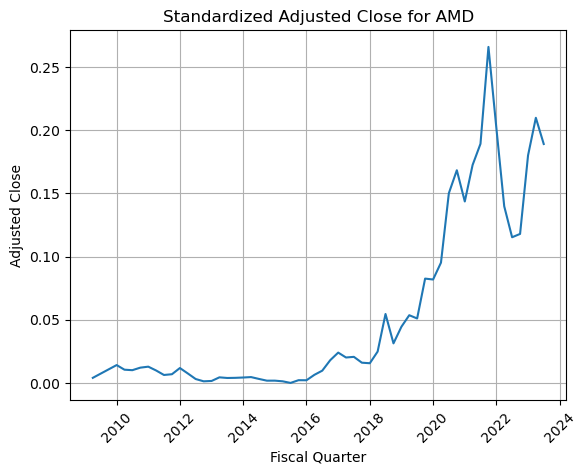

In [54]:
# Graph fiscal quarter standardized for AMD ticker

# Filter the DataFrame for the "AMD" ticker
amd_df = df[df['CRSP Ticker'] == 'AMD']

# Plot the standardized Adjusted Close for visualization
plt.plot(amd_df['Fiscal Quarter'], amd_df['Adj Close MinMax'])
plt.xlabel('Fiscal Quarter')
plt.ylabel('Adjusted Close')
plt.title('Standardized Adjusted Close for AMD')
plt.xticks(rotation=45)
plt.grid()
plt.show()

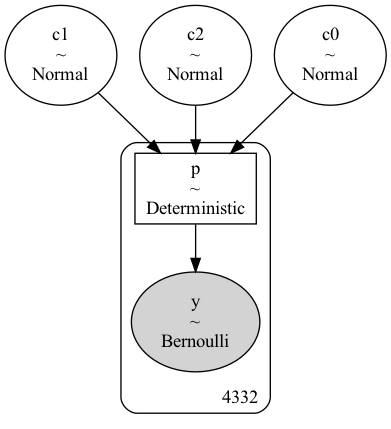

In [59]:
# Create arrays for CEO dismissal and adjusted close for PyMC
ceo_dismissal = np.array(df['CEO Dismissal'])
adj_close = np.array(df['Adj Close MinMax'])

# Create a PyMC model
with pm.Model() as pymc_model:
    # Define the priors
    c0 = pm.Normal('c0', mu=0, sigma=1)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    
    # Model
    logits = c0 + c1 * adj_close + c2 * date_standardized
    
    # Probit link for probability of dismissal
    p = pm.Deterministic('p', pm.math.invprobit(logits))

    # Define the likelihood
    y = pm.Bernoulli('y', p=p, observed=ceo_dismissal)
    
from IPython.display import Image
Image(pm.model_to_graphviz(pymc_model).render(format='png'))


In [60]:
# Run the inference
with pymc_model:
    trace1 = pm.sample()
    pm.sample_posterior_predictive(trace1, extend_inferencedata=True)
    pm.compute_log_likelihood(trace1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
Sampling: [y]


Output()

Output()

array([<Axes: title={'center': 'c0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

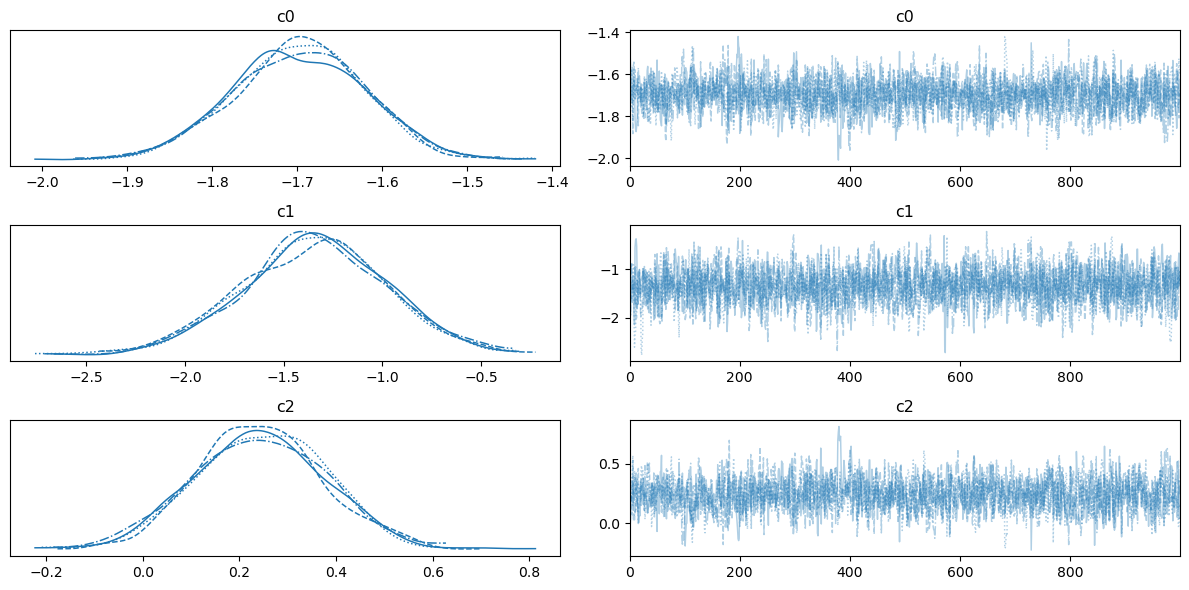

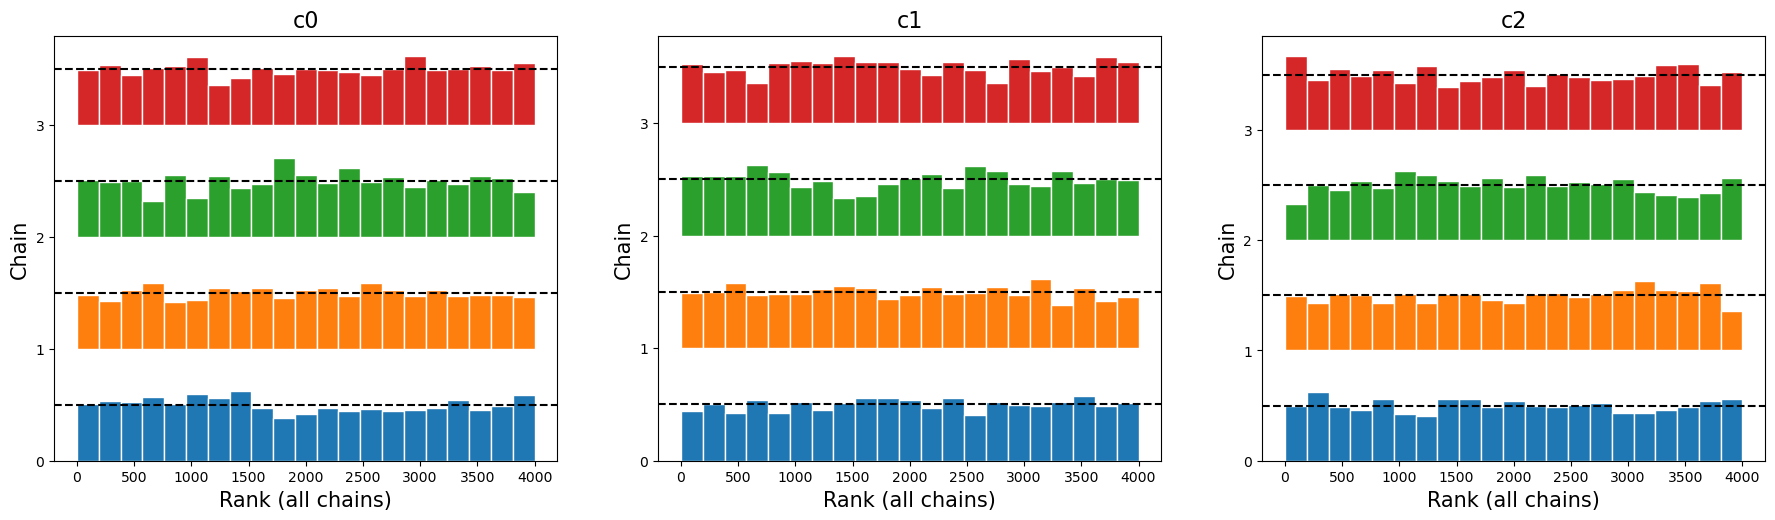

In [71]:
import arviz as az
# Let's visualize PyMC's performance
var_names = ['c0','c1','c2']
az.plot_trace(trace1, var_names)
plt.tight_layout()
az.plot_rank(trace1, var_names)

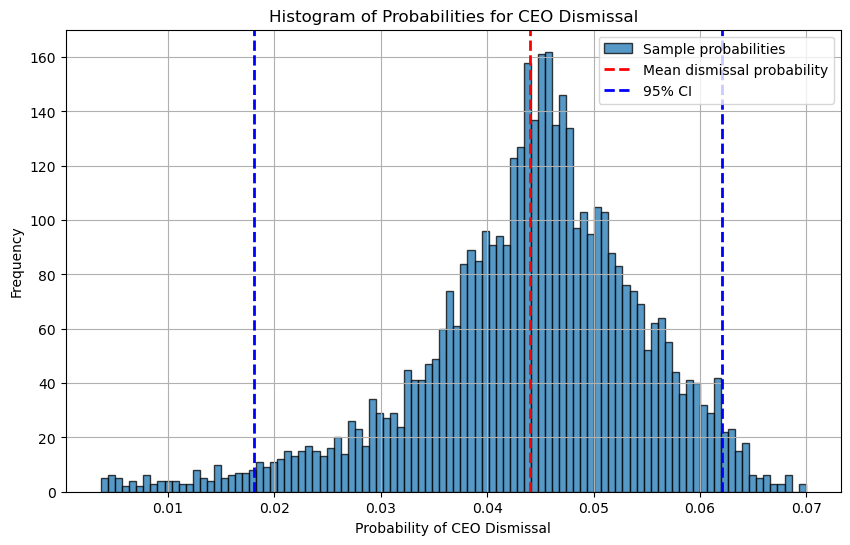

In [65]:
# Visualize the probabilities
posterior = trace1.posterior
probabilities = posterior['p'].values
mean_prob_dismissal_probit = probabilities.mean(axis = (0,1))
mean_prob_dismissal_probit
plt.figure(figsize=(10, 6))
plt.hist(mean_prob_dismissal_probit, bins=100, alpha=0.75,  edgecolor='black', label='Sample probabilities')
plt.axvline(x=np.mean(mean_prob_dismissal_probit), color='red', linestyle='dashed', linewidth=2, label='Mean dismissal probability')
plt.axvline(x=np.percentile(mean_prob_dismissal_probit, 2.5), color='blue', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(x=np.percentile(mean_prob_dismissal_probit, 97.5), color='blue', linestyle='dashed', linewidth=2)  
plt.xlabel('Probability of CEO Dismissal')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities for CEO Dismissal')
plt.legend()
plt.grid()
plt.show()

In [77]:
print(f'Mean dismissal probability: {round(np.mean(mean_prob_dismissal_probit),4)}')

Mean dismissal probability: 0.0441


In [68]:
az.summary(trace1, var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-1.698,0.078,-1.850,-1.562,0.002,0.001,1935.0,1958.0,1.0
c1,-1.344,0.367,-2.049,-0.667,0.008,0.006,2173.0,1901.0,1.0
c2,0.242,0.136,-0.001,0.504,0.003,0.003,1593.0,2080.0,1.0


In [75]:
# ELBO
pooled_loo = az.loo(trace1)
display(pooled_loo)

Computed from 4000 posterior samples and 4332 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -774.21    41.23
p_loo        2.65        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4332  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### ADVI 
Based on the results Evidence Lower Bound of this model is -774.21. This is a measure of how well the model fits the data. The lower the value, the better the fit. Now, I will use neural networks and compare them to PyMC which by default uses Mean-Field approximation method for variational inference. Variational inference or Automatic Differentiation Variational Inference - ADVI is an optimization method that optimizes a parametric model to approximate the posterior distribution. It includes maximizing the Evidence Lower Bound (ELBO) that indirectly provides an approximation to the model evidence. Integral part of ADVI is Variational Inference which is used to approximate complex distribution by finding a simpler/variational distribution that is close to the true distribution. The goal of Variational Inference is to minimize the Kullback-Leibler divergence between the true distribution and the variational distribution. The Kullback-Leibler divergence is a measure of how one probability distribution diverges from a second probability distribution. If we denote the true distribution as $P(\theta)$ and the variational distribution as $Q(\theta)$, the Kullback-Leibler divergence between two distributions $P$ and $Q$ is given by:

<center>

$ D_{KL}(P(\theta)|Q(\theta)) = \int P(\theta)ln(\frac{P(\theta)}{Q(\theta)})\,d\theta $

</center>

Which is a continuous form of KL divergence. In short, KL divergence measures the relative entropy of difference in information represented by two distributions. It can be understood as measuring the distance between two distributions showing how much information is lost when the variational distribution is used to approximate the true distribution. The ratio $\frac{P(\theta)}{Q(\theta)}$ represents how much more or less likely an event $\theta$ is under the true distribution compared to the variational distribution. The result is multiplied by the true distribution and integrated over the parameter space. The goal of Variational Inference is to minimize the KL divergence between the true distribution and the variational distribution. However, KL divergence is not always tractable and can be difficult to compute. Therefore, Variational Inference uses the Evidence Lower Bound (ELBO) to approximate the KL divergence. ELBO is equivalent to minimizing the KL divergence and is given by:
<center>

$ ELBO(\phi) = E_{Q(\theta|\phi)}[ln(P((D|\theta)))] + E_{Q(\theta|\phi)}[ln(P(\theta))] - E_{Q(\theta|\phi)}[ln(Q(\theta|\phi))] $

<br />

$ = E_{Q(\theta|\phi)} [ln(P(D,\theta)) - ln(Q(\theta|\phi))] $

</center>

Here, $Q(\theta)$ is the variational distribution that we use to approximate the true posterior distribution $P(D|\theta),$ where D is data and $\theta$ and $\phi$ are model parameters. The first part of the formula $E_{Q(\theta|\phi)} ln(P(D,\theta))$ is the expected log joint likelihood which measures how well the model P with parameter $\theta$ explains the observed data with respect to the variational distribution $Q_(\theta|\phi)$. Second part of the formula is the expected log of the variational distribution which acts as a form of entropy and acts as a loss function of using the variational distribution to approximate the true posterior. Minimizing this term ensures that the variational distribution is close to the true posterior distribution therefore, maximizing the ELBO.
So the objective in Variational Inference becomes finding solutions to maximize the ELBO:

<center>

$ \phi^* = argmax_{ELBO}(\phi) $

</center>


To maximize ELBO using this approach can computationally expensive since it needs to update the parameters $\phi$ in variational distribution until the ELBO converges. Instead alternative method to maximize the ELBO is ADVI which isa gradient based method. We still use iterative optimization to obtain $\phi^*$ but we use stochastic gradient decent which requires computing derivatives of ELBO with respect tothe parameters while relying on automatic differentiation libraries to compute derivatives. In ADVI the ELBO's model parameters have support on the real line so a suitable variational distribution for parameter $\zeta$ is a multivariate Normal distribution which serves as the variational distribution allowing to compute the expectation and its gradient using a Monte Carlo estimate. Thus, to maximize the ELBO, the gradient of the ELBO with respect to the variational parameters is calculated:  
<center>

$ \nabla_{\phi}ELBO(\phi) = \nabla_{\phi}E_{q(\zeta|\phi)}[ln(P(D,T^{-1}(\zeta)))+log|det J_{T^{-1}}(\zeta)| - ln(Q(\zeta|\phi))]$
<br />
$ \nabla_{\phi}ELBO(\phi) \approx ln(P(D,T^{-1}(\hat{\zeta})))+log|det J_{T^{-1}}(\hat{\zeta})| - ln(Q(\hat{\zeta}|\phi)) $

</center>

The first expression above draws a standard Normal random variate and multiplies it by variational standard deviation and variational mean allowing us to push the gradient inside ofthe expectation. The second expression is the Monte Carlo estimate of the gradient of the ELBO where $\hat{\zeta}=\mu+z\sigma,$ $z$ is a draw from a standard Normal distribution and $\mu$ and $\sigma$ is the variational mean and standard deviation. The gradient of the ELBO is then used to update the variational parameters $\phi$ until the ELBO converges. 
The simplified process to use ADVI algorithm is as follows:
1. Choose a variational distribution to approximate the posterior distribution.
2. Transform the variational distribution to unconstrained space using a logarithmic transformation.
3. Automatic differentiation: set up the graph of the model and the variational family and use automatic differentiation library to compute gradients  of the ELBO with respect to the variational parameters.
4. Calculate ELBO by taking expectation of the logarithm ofthe joint distribution and the entropy (loss). Use Monte Carlo estimate to calculate the gradient of the ELBO since the analytical solution is often unfeasible.
5. Use stochastic gradient ascent to find variational parameters that maximize the ELBO.
6. Check whether the ELBO has converged. If not, repeat steps 3-5 until convergence.

To summarize, ELBO offers offers a close approximation to the true log model evidence. This can be done either by maximizing ELBO or minimizing the negative of the ELBO. This process will give us an estimate of log model evidence in a form of variational distribution. The main advantage of ADVI is that it is computationally efficient and can be used for complex models. However, ADVI is sensitive to the choice of variational distribution and can be sensitive to the initial values of the variational parameters.

In [84]:
# Reshape the input arrays to 2D arrays
adj_close = adj_close.reshape(-1, 1)  # Reshape to a column vector

# Split the data into training and testing sets
adj_close_train, adj_close_test, ceo_train, ceo_test = train_test_split(adj_close, ceo_dismissal, test_size=0.2, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(adj_close_train, ceo_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(adj_close_test, ceo_test)
print("Test Accuracy:", accuracy)

# Make predictions
predictions = model.predict(adj_close_test)

Epoch 1/10
98/98 [==============================] - 3s 6ms/step - loss: 0.3955 - accuracy: 0.9551 - val_loss: 0.1522 - val_accuracy: 0.9683
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.9551 - val_loss: 0.1453 - val_accuracy: 0.9683
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.1851 - accuracy: 0.9551 - val_loss: 0.1431 - val_accuracy: 0.9683
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.1842 - accuracy: 0.9551 - val_loss: 0.1459 - val_accuracy: 0.9683
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.9551 - val_loss: 0.1451 - val_accuracy: 0.9683
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.9551 - val_loss: 0.1446 - val_accuracy: 0.9683
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.1835 - accuracy: 0.9551 - val_loss: 0.1433 - val_accuracy: 0.9683
Epoch 8/10
98/98 [==

In [100]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

# Calculate accuracy
accuracy = accuracy_score(ceo_test, predictions.round())
# Calculate precision
precision = precision_score(ceo_test, predictions.round())
# Calculate recall
recall = recall_score(ceo_test, predictions.round())
# Calculate F1-score
f1 = f1_score(ceo_test, predictions.round())
# Calculate ROC AUC score
roc_auc = roc_auc_score(ceo_test, predictions)
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(ceo_test, predictions)

# Print the metrics
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC AUC Score:", roc_auc)


Accuracy: 0.9550173010380623
F1-score: 0.0
ROC AUC Score: 0.6738201412114455


/Users/giorgikukishvili/Documents/Giorgi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
